In [1]:
import numpy as np
import cv2
import os

In [ ]:
def generate_bouncing_ball_sequence_no_gravity(
    seq_len=10, 
    frame_size=224, 
    ball_radius=20, 
    ball_color=(255, 255, 255), 
    bg_color=(0, 0, 0),
    velocity_range=(5, 10)
):
    # Random initial position and velocity
    x = np.random.randint(ball_radius, frame_size - ball_radius)
    y = np.random.randint(ball_radius, frame_size - ball_radius)
    vx = np.random.choice([-1, 1]) * np.random.randint(*velocity_range)
    vy = np.random.choice([-1, 1]) * np.random.randint(*velocity_range)
    
    frames = []
    for _ in range(seq_len):
        frame = np.full((frame_size, frame_size, 3), bg_color, dtype=np.uint8)
        cv2.circle(frame, (int(x), int(y)), ball_radius, ball_color, -1)
        frames.append(frame)
        
        # Update position
        x += vx
        y += vy
        
        # Bounce off walls
        if x - ball_radius < 0 or x + ball_radius > frame_size:
            vx *= -1
            x += vx
        if y - ball_radius < 0 or y + ball_radius > frame_size:
            vy *= -1
            y += vy
    return frames

def save_sequence(frames, out_dir, seq_idx):
    os.makedirs(out_dir, exist_ok=True)
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(out_dir, f"seq{seq_idx:04d}_frame{i:02d}.png"), frame)

def generate_dataset(num_sequences=100, seq_len=10, out_dir="bouncing_ball_dataset"):
    for seq_idx in range(num_sequences):
        frames = generate_bouncing_ball_sequence_no_gravity(seq_len=seq_len)
        save_sequence(frames, out_dir, seq_idx)

def generate_continuous_dataset(total_frames=1000, out_dir="bouncing_ball_dataset"):
    os.makedirs(out_dir, exist_ok=True)
    frames = generate_bouncing_ball_sequence_no_gravity(seq_len=total_frames)
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(out_dir, f"frame{i:06d}.png"), frame)

In [3]:
def generate_bouncing_balls_sequence(
    num_balls=3,
    seq_len=10,
    frame_size=224,
    ball_radius=20,
    ball_colors=None,   # list of scalars or RGB tuples
    bg_color=0,         # single scalar grayscale
    speed_range=(1, 3),
    gravity=0.1,        # mutual attraction strength
    softening=1e-2,     # avoid singularity
    dt=1.0,             # timestep
    restitution=0.9,    # bounce restitution coefficient
    n_substeps=4        # number of sub-steps per frame
):
    # init colors (grayscale scalars 0-255)
    if ball_colors is None:
        # ball_colors = [int(np.random.randint(50, 256)) for _ in range(num_balls)]
        ball_colors = [255 for _ in range(num_balls)]
    else:
        conv = []
        for c in ball_colors:
            if hasattr(c, "__len__") and len(c) == 3:
                r, g, b = c
                lum = int(round(0.299 * r + 0.587 * g + 0.114 * b))
                conv.append(lum)
            else:
                conv.append(int(c))
        ball_colors = conv

    # positions (ensure no initial overlap)
    positions = np.zeros((num_balls, 2), dtype=float)
    for i in range(num_balls):
        while True:
            x = np.random.uniform(ball_radius, frame_size - ball_radius)
            y = np.random.uniform(ball_radius, frame_size - ball_radius)
            pos = np.array([x, y])
            ok = True
            for j in range(i):
                if np.linalg.norm(pos - positions[j]) < (2 * ball_radius):
                    ok = False
                    break
            if ok:
                positions[i] = pos
                break

    # velocities: random direction * speed
    velocities = np.zeros((num_balls, 2), dtype=float)
    for i in range(num_balls):
        angle = np.random.uniform(0, 2 * np.pi)
        speed = np.random.uniform(*speed_range)
        velocities[i] = np.array([np.cos(angle), np.sin(angle)]) * speed

    # add parameters: restitution=0.9, n_substeps=4 to function signature

    frames = []
    for _ in range(seq_len):
        dt_sub = dt / max(1, n_substeps)
        for _sub in range(n_substeps):
            # gravity: pairwise mutual attraction (softened)
            if gravity != 0:
                accs = np.zeros_like(velocities)
                for i in range(num_balls):
                    acc = np.zeros(2, dtype=float)
                    for j in range(num_balls):
                        if i == j:
                            continue
                        delta = positions[j] - positions[i]
                        r = np.linalg.norm(delta)
                        if r == 0:
                            continue
                        denom = (r * r + softening * softening) ** 1.5
                        acc += gravity * delta / denom
                    accs[i] = acc
                velocities += accs * dt_sub

            # update positions
            positions += velocities * dt_sub

            # wall collisions
            for i in range(num_balls):
                if positions[i, 0] - ball_radius < 0:
                    positions[i, 0] = ball_radius
                    velocities[i, 0] *= -1
                if positions[i, 0] + ball_radius > frame_size:
                    positions[i, 0] = frame_size - ball_radius
                    velocities[i, 0] *= -1
                if positions[i, 1] - ball_radius < 0:
                    positions[i, 1] = ball_radius
                    velocities[i, 1] *= -1
                if positions[i, 1] + ball_radius > frame_size:
                    positions[i, 1] = frame_size - ball_radius
                    velocities[i, 1] *= -1

            # ball-ball collisions (pairwise) with restitution
            for i in range(num_balls):
                for j in range(i + 1, num_balls):
                    delta = positions[i] - positions[j]
                    dist = np.linalg.norm(delta)
                    min_dist = 2 * ball_radius
                    if dist == 0:
                        n = np.random.randn(2)
                        n /= np.linalg.norm(n)
                        dist = 1e-6
                    else:
                        n = delta / dist

                    if dist < min_dist:
                        overlap = min_dist - dist
                        positions[i] += n * (overlap / 2.0)
                        positions[j] -= n * (overlap / 2.0)

                        t = np.array([-n[1], n[0]])

                        v_i_n = np.dot(velocities[i], n)
                        v_i_t = np.dot(velocities[i], t)
                        v_j_n = np.dot(velocities[j], n)
                        v_j_t = np.dot(velocities[j], t)

                        # swap normal components then apply restitution (<1 reduces bounce)
                        v_i_n_after = v_j_n * restitution
                        v_j_n_after = v_i_n * restitution

                        velocities[i] = v_i_n_after * n + v_i_t * t
                        velocities[j] = v_j_n_after * n + v_j_t * t

        # draw single-channel frame after sub-steps
        frame = np.full((frame_size, frame_size), bg_color, dtype=np.uint8)
        for i in range(num_balls):
            cv2.circle(frame, (int(positions[i, 0]), int(positions[i, 1])), ball_radius, int(ball_colors[i]), -1)
        frames.append(frame)

    return frames

In [4]:
def generate_seq_folder_dataset(
    num_sequences=100,
    out_dir="bouncing_balls_dataset",
    num_balls=3,
    seq_len=128,
    ball_radius=10,
    frame_size=256,
    speed_range=(3, 6),
    **kwargs
    ):

    os.makedirs(out_dir, exist_ok=True)

    for seq_idx in range(num_sequences):

        frames = generate_bouncing_balls_sequence(
            num_balls=num_balls,
            seq_len=seq_len,
            frame_size=frame_size,
            ball_radius=ball_radius,
            speed_range=speed_range,
            **kwargs
        )

        seq_dir = os.path.join(out_dir, f"seq{seq_idx:04d}")
        os.makedirs(seq_dir, exist_ok=True)
        
        for i, frame in enumerate(frames):
            cv2.imwrite(os.path.join(seq_dir, f"frame{i:03d}.png"), frame)

## Generate the Dataset

In [5]:
generate_seq_folder_dataset(num_sequences=500, num_balls=2, seq_len=256, gravity=0, ball_radius=28, speed_range=(5, 6), frame_size=256)

## Look into the Frames

In [51]:
frames = generate_bouncing_balls_sequence(num_balls=2, seq_len=50, gravity=2500, ball_radius=24, speed_range=(3, 6), frame_size=256)

KeyboardInterrupt: 

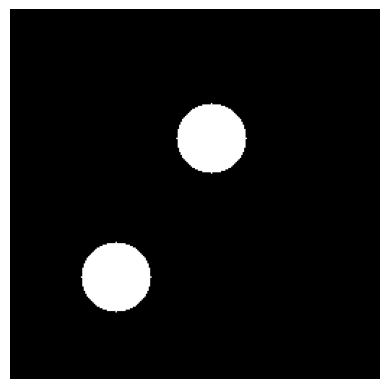

In [52]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

for frame in frames[:100]:
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    display(plt.gcf())
    # plt.pause(0.03)